TokaMaker Example: MANTA baseline case
==========

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python packages. Both of which are installable using `pip` or other standard methods.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import json as js

plt.rcParams['figure.figsize']=(6,6)
#plt.rcParams['font.weight']='bold'
#plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

""" plt.rcParams.update({
    "text.usetex": False,
    # "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "font.size": 30
})  """

' plt.rcParams.update({\n    "text.usetex": False,\n    # "font.family": "serif",\n    # "font.serif": ["Computer Modern Roman"],\n    "font.size": 30\n})  '

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done through the script using `sys.path.append()` as below.

In [2]:
tokamaker_python_path = '/home/jerem/tokamaker/OpenFUSIONToolkit/libs/install_release'
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))

from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

## Compute equilibria

### Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          6165a5a
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /tmp/oft_1088/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  10
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated in \ref doc_gs_mesh_ex2 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions" to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [4]:
MANTA_EQ = read_eqdsk('MANTA_posCS_final')

mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('MANTA_mesh.h5')

mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict, coil_dict=coil_dict)
mygs.setup(order = 3, F0 = MANTA_EQ['bcentr']*MANTA_EQ['rcentr'])


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  7.741E+01
    # of points  =   13632
    # of edges   =   40659
    # of cells   =   27028
    # of boundary points =     234
    # of boundary edges  =     234
    # of boundary cells  =     234
  Resolution statistics:
    hmin =  2.852E-03
    hrms =  8.651E-02
    hmax =  2.243E-01
  Surface grounded at vertex    1365


**** Creating Lagrange FE space
  Order  =    3
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    3.5470163999999998E-002


### Visualization

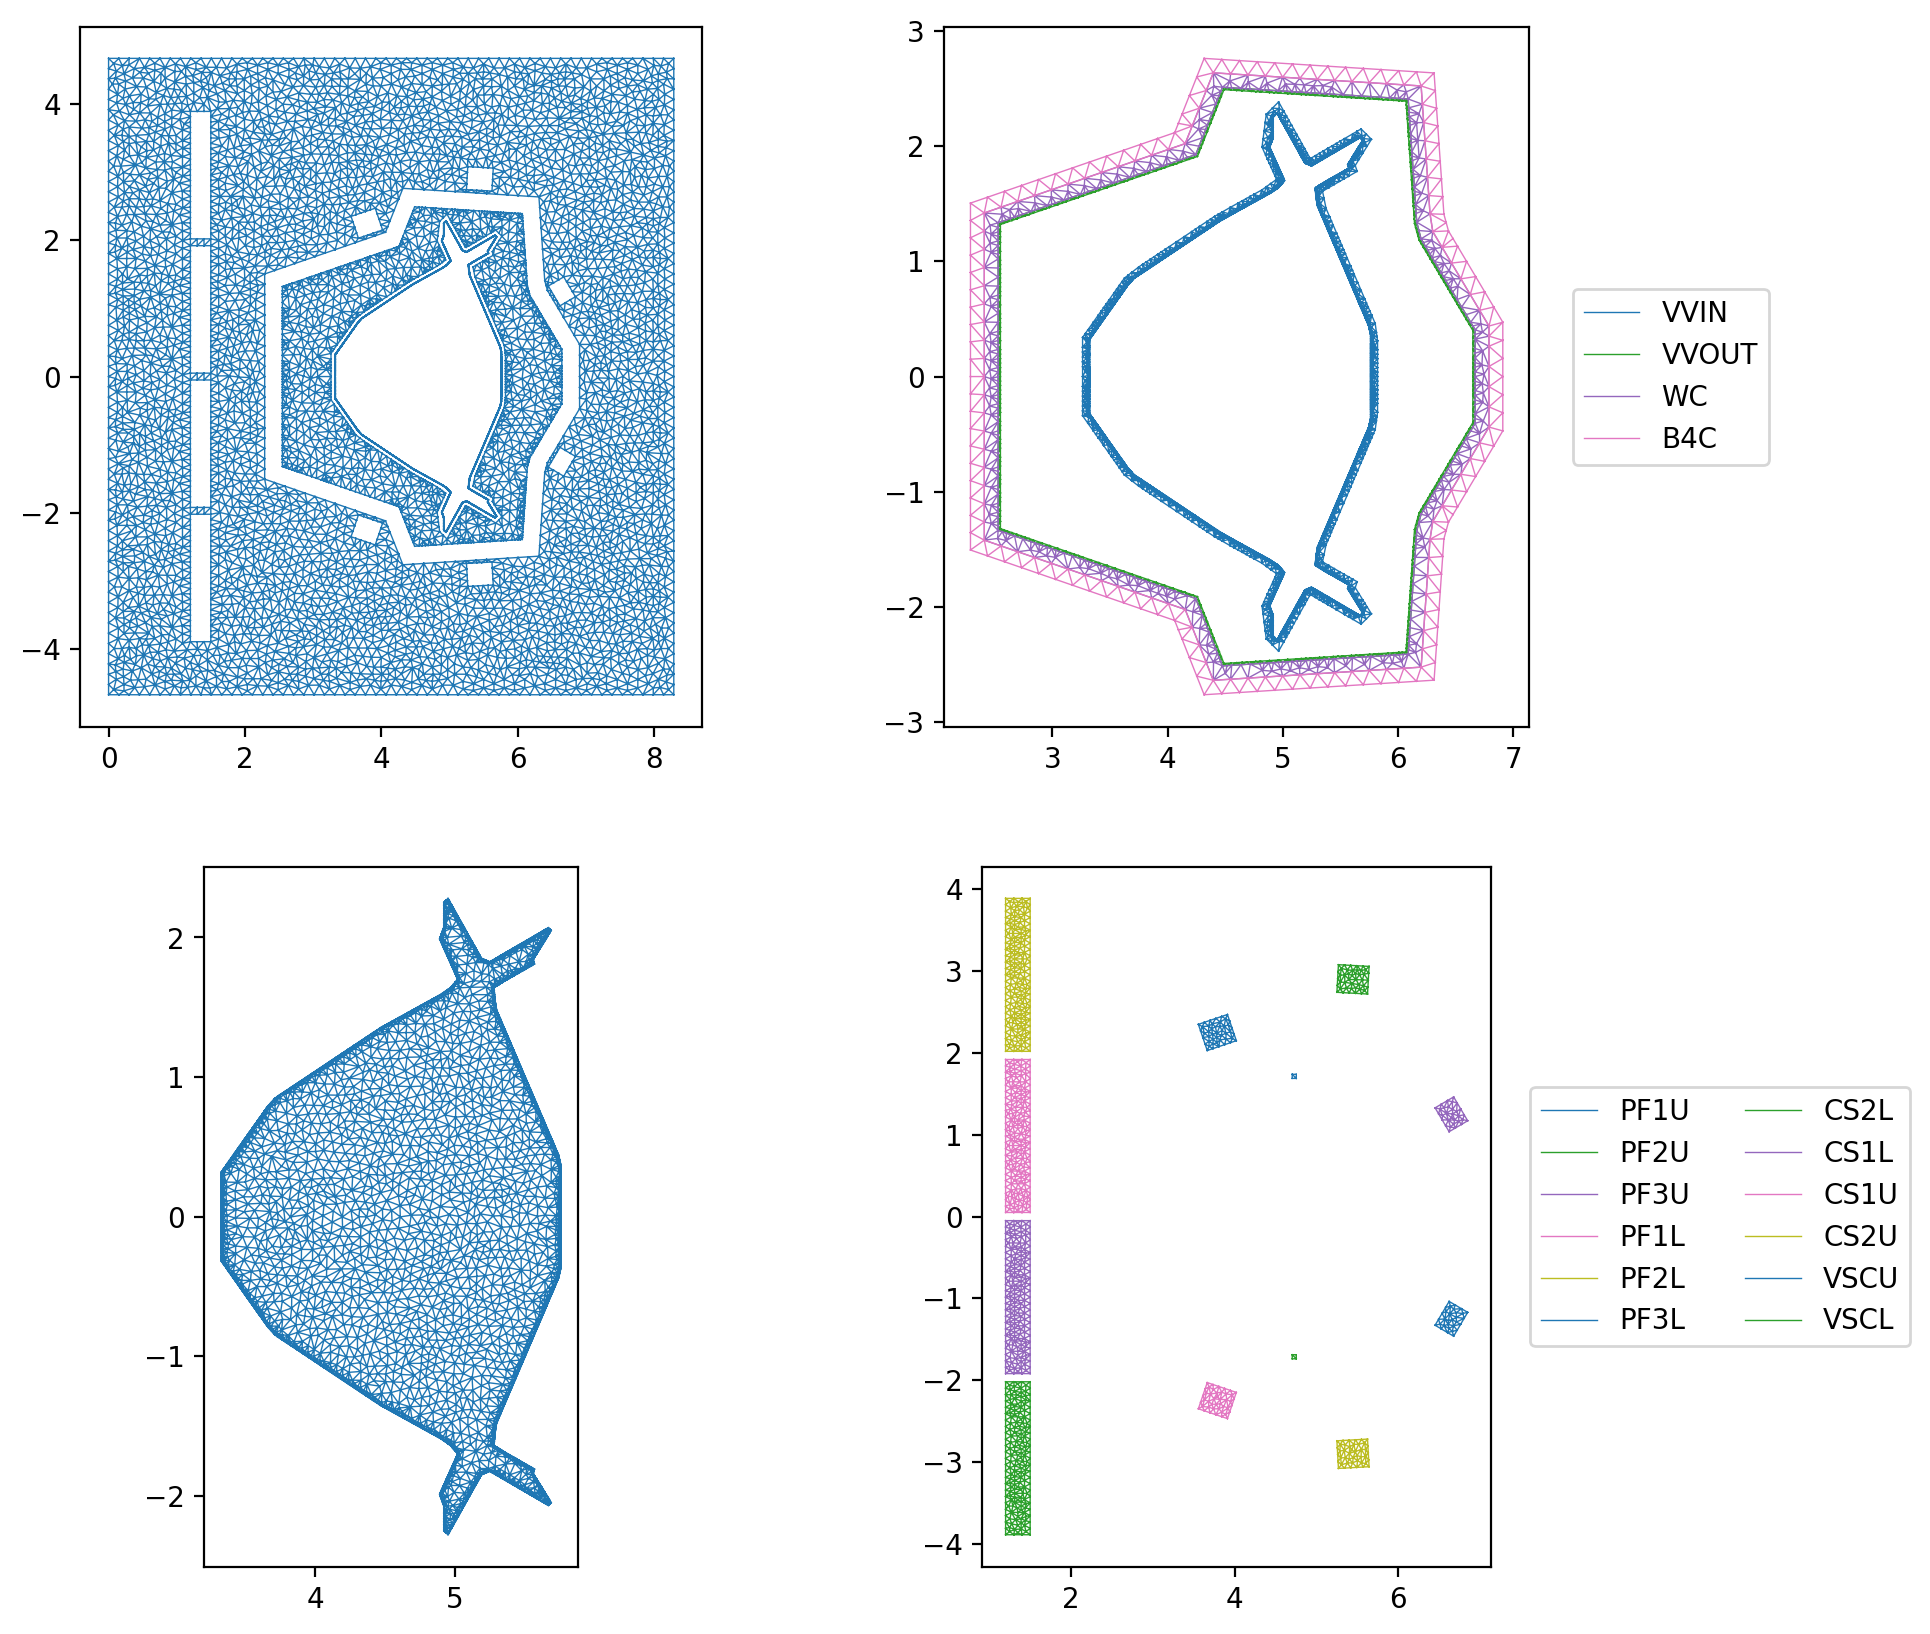

In [5]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==2,:],lw=0.5)
ax[1,0].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==1,:],lw=0.5)
for key, cond in cond_dict.items():
    ax[0,1].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==cond['reg_id'],:],lw=0.5,label=key)
for key, coil in coil_dict.items():
    ax[1,1].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==coil['reg_id'],:],lw=0.5,label=key)
for ax_tmp in ax.flatten():
    ax_tmp.set_aspect('equal','box')
ax[0,1].legend(bbox_to_anchor=(1.05,0.5), loc='center left')
_ = ax[1,1].legend(bbox_to_anchor=(1.05,0.5), ncol=2, loc='center left')

### Define a vertical stability coil
Like many elongated equilibria, the equilibrium we seek to compute below is vertically unstable. So we define a pair of coils, and corresponding polarities, that will be used to control the vertical position in the equilibrium solve. In this case we use the actual ITER Vertical Stability Coil (VSC).

In [6]:
vsc = 'VSC'
mygs.set_coil_vsc({f'{vsc}U': 1.0, f'{vsc}L': -1.0})

### Define hard limits on coil currents
Hard limits on coil currents can be set using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_bounds "set_coil_bounds". In this case we just the simple and approximate bi-directional limit of 50 MA in each coil.

Note that the size of the bounds array is (ncoils+1,2) as bounds can also be set for the VSC set, which is treated as a separate degree of freedom (virtual coil) if defined.

In [8]:
coil_bounds = {key: [-20.E6, 20.E6] for key in mygs.coil_sets}
mygs.set_coil_bounds(coil_bounds)

## Compute Inverse Equilibrium

### Define global quantities and targets
For the inverse case we define a target for the plasma current and the peak plasma pressure, which occurs on the magnetic axis.

**Note:** These constraints can be considered "hard" constraints, where they will be matched to good tolerance as long as the calculation converges.

In [15]:
Ip_target=9.995E6
P0_target=MANTA_EQ['pres'][0]
mygs.set_targets(Ip=Ip_target, pax=P0_target)

### Define shape targets
In order to constrain the shape of the plasma we can utilize two types of constraints:
 1. `isoflux` points, which are points we want to lie on the same flux surface (eg. the LCFS)
 2. `saddle` points, where we want the poloidal magnetic field to vanish (eg. X-points). While one can also use this constraint to enforce a magnetic axis location, instead \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_targets "set_targets" should be used with arguments `R0` and `V0`.

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

Here we define a handful of isoflux points that we want to lie on the LCFS of the target equilibrium. Additionally, we define a single X-point and set it as a saddle constraint as well as adding it to the list of isoflux points.

In [16]:
lcfs_contour = MANTA_EQ['rzout'][:-1,:][::200]

x_point1 = [5.15369, 1.69138]
x_point2 = [5.15369, -1.67138]
isoflux_pts = np.vstack((lcfs_contour[np.logical_or(np.abs(lcfs_contour[:,1])>1.,np.abs(lcfs_contour[:,1])<1),:],[x_point1,x_point2]))

x_point = np.array([x_point1,x_point2])
boundary = np.vstack((isoflux_pts,x_point))

weights = np.ones(len(boundary[:,0]))*10

weights[-2:] = 1e2

mygs.set_isoflux(boundary, weights=weights)
mygs.set_saddles(x_point, weights= np.asarray([1e2,1e2]))

### Define coil regularization matrix
In general, for a given coil set a given plasma shape cannot be exactly reproduced, which generally yields large amplitude coil currents if no constraint on the coil currents is applied. As a result, it is useful to include regularization terms for the coils to balance minimization of the shape error with the amplitude of current in the free coils. In TokaMaker these regularization terms have the general form of a vector of targets (often zero), a regularization matrix that maps the coil currents to the targets, and a vector of weights that can be used to control the relative impact of each term in the minimization.

Here we use the identity as the regularization matrix, with zero for all targets and modest weights on the CS and PF coils. This regularization acts to penalize the amplitude of current in each coil, acting to balance coil current with error in the shape targets. Note that the VSC set has a large weight as we also use the regularization matrix to prevent up-down symmetric current in these coils. The actual up-down asymmetric current will be provided by the dedicated VSC virtual coil.

In [17]:
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = np.ones((mygs.ncoils+1,))
coil_reg_targets = np.zeros((mygs.ncoils+1,))

# Set regularization weights
for key, coil in coil_dict.items():
    if key.startswith('CS'):
        if key.endswith('U'):
            suff = 'L'
        else:
            suff = 'U'
        coil_reg_mat[coil['coil_id'],coil_dict[key[:-1] + suff]['coil_id']] = -1
        #coil_reg_weights[coil['coil_id']] = 0.2E-2

    elif key.startswith('PF'):
        
        if key.endswith('U'):
            suff = 'L'
        else:
            suff = 'U'
        coil_reg_mat[coil['coil_id'],coil_dict[key[:-1] + suff]['coil_id']] = -1
        coil_reg_weights[coil['coil_id']] = 1.E1
    elif key.startswith('VS'):
        coil_reg_weights[coil['coil_id']] = 1.E1 # Force "regular" current to zero in VSC
# Set weight for VSC virtual coil
coil_reg_weights[-1] = 1.E-2
# coil_reg_weights[coil_dict['PF2L']['coil_id']] = 0.9E-2

print(coil_dict.keys())
print(coil_reg_mat)

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(coil_reg_mat, reg_weights=coil_reg_weights, reg_targets=coil_reg_targets)

dict_keys(['PF1U', 'PF2U', 'PF3U', 'PF1L', 'PF2L', 'PF3L', 'CS2L', 'CS1L', 'CS1U', 'CS2U', 'VSCU', 'VSCL'])
[[ 1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


### Define flux functions
We simply use the profiles obtained through robust kinetic codes in the original MANTA paper.

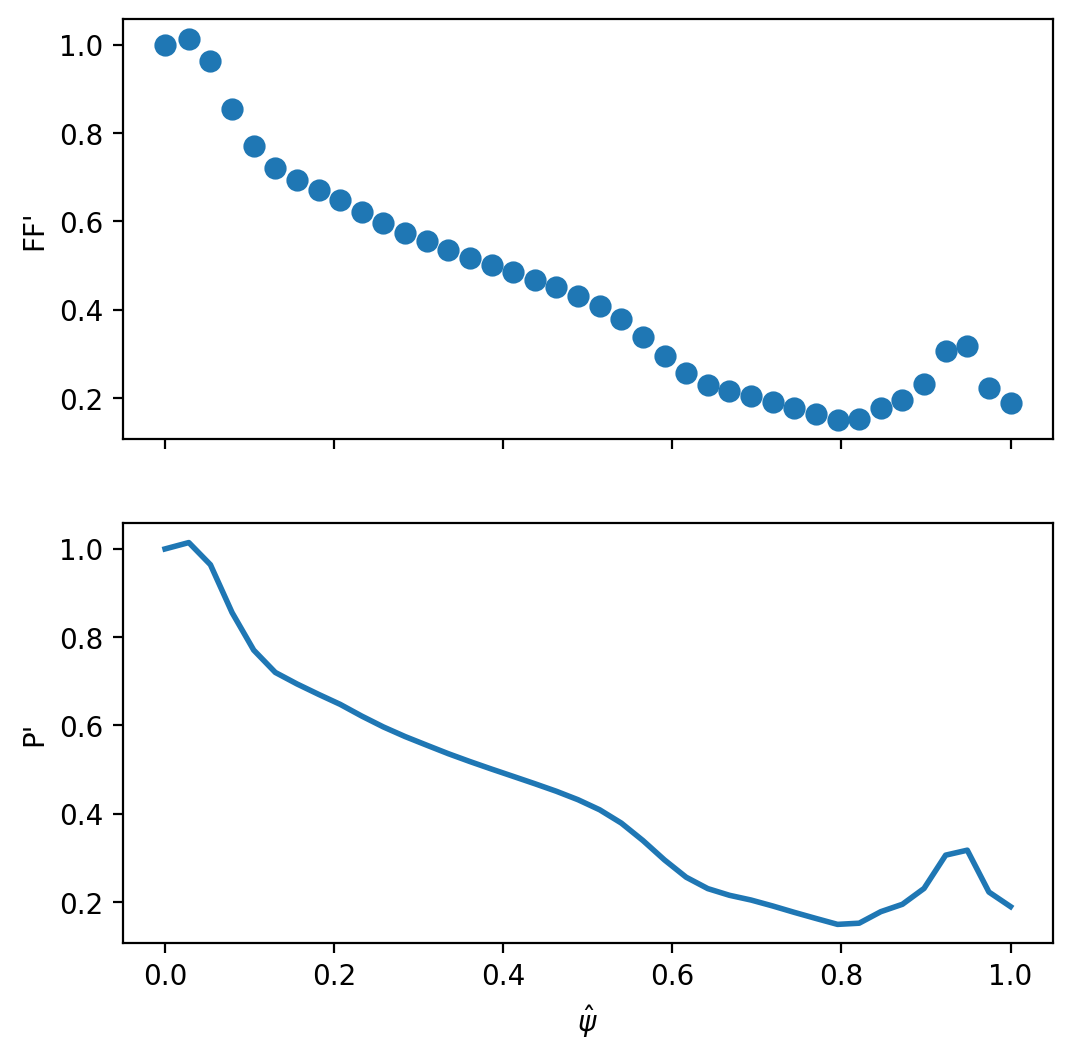

In [18]:
n_sample = 40
psi_sample = np.linspace(0.0025,1.0,n_sample)
psi_eqdsk = np.linspace(0.0,1.0,MANTA_EQ['nr'])
psi_prof = psi_sample.copy(); psi_prof[0]=0.0 # Extent profile to core


# Set F*F' profile
ffp_prof = {
    'type': 'linterp',
    'x': psi_prof,
    'y': np.interp(psi_sample,psi_eqdsk,MANTA_EQ['ffprim'])
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)

# Set P' profile
pp_prof = {
    'type': 'linterp',
    'x': psi_prof,
    'y': np.interp(psi_sample,psi_eqdsk,MANTA_EQ['ffprim'])
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'],'o')
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)


### Compute equilibrium
We can now compute a free-boundary equilibrium using these constraints. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.init_psi "init_psi". This subroutine initializes the flux using the specified Ip_target from above, which is evenly distributed over the entire plasma region or only with a boundary defined using a center point (R,Z), minor radius (a), and elongation and triangularity. Coil currents are also initialized at this point using the constraints above and this uniform plasma current initialization. 

\ref OpenFUSIONToolkit.TokaMaker.TokaMaker.solve "solve" is then called to compute a self-consitent Grad-Shafranov equilibrium. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [19]:
R0 = MANTA_EQ['raxis']
Z0 = MANTA_EQ['zaxis']
a = 1.25
kappa = 1.4
delta = -0.4
print(R0, Z0, a, kappa, delta)
err_flag = mygs.init_psi(R0, Z0, a, kappa, delta)
err_flag = mygs.solve()

4.549215598 3.485445469e-14 1.25 1.4 -0.4
Starting non-linear GS solver
     1 -2.9095E-02  1.4261E+00  4.4043E-02  4.6901E+00 -5.7050E-03  9.7405E+04
     2  2.9589E+01  7.1638E-01  1.5760E-02  4.6938E+00 -3.4967E-03  8.4847E+04
     3  3.1484E+01  6.9732E-01  6.8482E-03  4.6943E+00 -1.9674E-03  5.8497E+04
     4  3.2071E+01  6.9448E-01  4.2971E-03  4.6937E+00 -1.0215E-03  4.7691E+04
     5  3.2316E+01  6.9397E-01  2.4092E-03  4.6927E+00 -4.7377E-04  4.4098E+04
     6  3.2438E+01  6.9367E-01  1.4272E-03  4.6919E+00 -1.6549E-04  4.2475E+04
     7  3.2510E+01  6.9351E-01  4.5840E-04  4.6913E+00  3.6569E-05  4.3190E+04
     8  3.2536E+01  6.9315E-01  2.8705E-04  4.6909E+00  1.7886E-04  4.3136E+04
     9  3.2544E+01  6.9308E-01  2.0929E-04  4.6907E+00  2.8667E-04  4.3022E+04
    10  3.2548E+01  6.9306E-01  1.9055E-04  4.6905E+00  3.6354E-04  4.2942E+04
    11  3.2549E+01  6.9306E-01  6.4683E-05  4.6904E+00  4.1920E-04  4.2881E+04
    12  3.2549E+01  6.9306E-01  4.2131E-05  4.6904E+00  4.5

### Plot equilibrium
Flux surfaces of the computed equilibrium can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi" method. The additional plotting methods \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_machine "plot_machine" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_constraints "plot_constraints" are also used to show context and other information. Each method has a large number of optional arguments for formatting and other options.

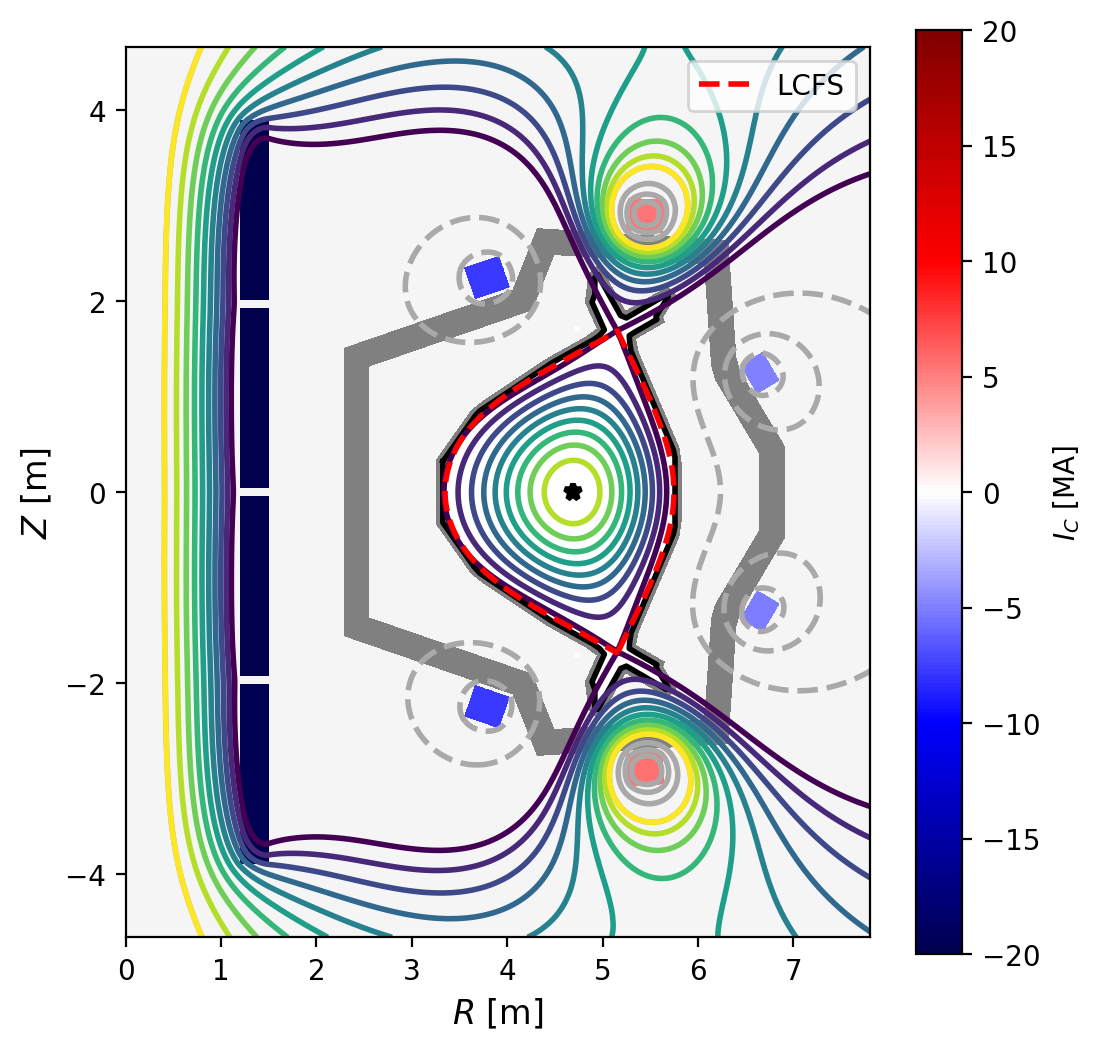

In [22]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
#mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=6,plasma_colormap='plasma',plasma_nlevels=13)
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4,plasma_nlevels=10)
# mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='.')
plt.plot(MANTA_EQ['rzout'][:,0], MANTA_EQ['rzout'][:,1], color='r', linestyle='--', label='LCFS')
plt.xlabel('$R$ [m]', fontsize=12)
plt.ylabel('$Z$ [m]', fontsize=12)
plt.xlim(0, 7.8)
plt.legend()

### Print equilibrium information and coil currents
Basic parameters can be displayed using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info" method. For access to these quantities as variables instead the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_stats "get_stats" can be used.

The final coil currents can also be retrieved using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_coil_currents "get_coil_currents" method, which are all within the approximate coil limits imposed above.

In [23]:
mygs.print_info()

print()
print("Coil Currents [MA]:")
coil_currents, currents_reg = mygs.get_coil_currents()

for key in coil_dict:
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[key]/1.E6))

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    9.9950E+06
  Current Centroid [m]    =    4.629  0.002
  Magnetic Axis [m]       =    4.690  0.001
  Elongation              =    1.412 (U:  1.461, L:  1.363)
  Triangularity           =   -0.534 (U: -0.557, L: -0.512)
  Plasma Volume [m^3]     =   145.355
  q_0, q_95               =    0.697  2.358
  Peak Pressure [Pa]      =    1.6355E+06
  Stored Energy [J]       =    9.4322E+07
  <Beta_pol> [%]          =   48.7955
  <Beta_tor> [%]          =    0.8697
  <Beta_n>   [%]          =    1.1260
  Diamagnetic flux [Wb]   =    2.7256E-01
  Toroidal flux [Wb]      =    5.5964E+01
  l_i                     =    0.8813

Coil Currents [MA]:
  PF1U:           -7.76
  PF2U:            5.32
  PF3U:           -4.96
  PF1L:           -7.71
  PF2L:            5.51
  PF3L:           -5.06
  CS2L:          -19.64
  CS1L:          -20.00
  CS1U:          -20.00
  CS2U:          -20.00
  VSCU:            0.02


#### Total current - Baseline (only PF coils)

In [25]:
total_pf_current = sum(
    abs(current)
    for name, current in coil_currents.items()
    if name.startswith("PF")
)

print("Total current generated by PF coils:", total_pf_current)

Total current generated by PF coils: 36325973.275233716


In [15]:
mygs.save_eqdsk('gMANTA_tkmkr',nr=150,nz=150)

Saving gEQDSK: gMANTA_tkmkr
